<a href="https://colab.research.google.com/github/nikhilnimbalkar1/STS/blob/master/STSmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Siamese Architecture 
This architecture is based on [this keras model ](https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb) , you can also try any other implementations from [this link](https://github.com/nikhilnimbalkar1?tab=stars).This is a very basic model and we need to enhance it a lot to get even 50%-60% accuracy,this model has 4%-5% accuracy right now.Try enhancing the model individually and share all progress.

In [0]:
%%capture
!pip3 install --upgrade tensorflow-gpu
!pip3 install --upgrade pip3


These install commands won't be necessary after 27 March 2020 as default Tensorflow version will switch to 2.x

In [3]:
!pip3 install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 450kB 51.4MB/s 
     |████████████████████████████████| 3.9MB 56.6MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import csv
import scipy
import tensorflow.keras.backend as K

Ensure you have tensorflow api v2 isntalled or there are some issues with training the final model that are not yet certain.

In [2]:
tf.version

<module 'tensorflow_core._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow_core/_api/v2/version/__init__.py'>

Load STS Dataset and clean up some values.

In [0]:
def load_sts_dataset():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

  sts_dev = pd.read_table(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
      error_bad_lines=False,
      skip_blank_lines=True,
      usecols=[4, 5, 6],
      names=["sim", "sent_1", "sent_2"])

  sts_test = pd.read_table(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
      error_bad_lines=False,
      quoting=csv.QUOTE_NONE,
      skip_blank_lines=True,
      usecols=[4, 5, 6],
      names=["sim", "sent_1", "sent_2"])

  sts_train = pd.read_table(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-train.csv"),
      error_bad_lines=False,
      quoting=csv.QUOTE_NONE,
      skip_blank_lines=True,
      usecols=[4, 5, 6],
      names=["sim", "sent_1", "sent_2"])
  # cleanup some NaN values in sts_dev
  sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]
  return sts_train,sts_test,sts_dev



Load Universal Sentence Encoder transformer model.Alternatively we can use DAN model too. 

In [0]:
def load_USE():
  use_model_url="https://tfhub.dev/google/universal-sentence-encoder-large/5"
  embed=hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
  return embed

Helper Function to calculate Manhattan Distance between the final output Tensors

In [0]:
def manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

Prepare Data and convert both sentences to embeddings seperately and convert the similarity column to Tensor type too.
Shuffling and Repeating the data from Tensorflow API should be used too to get accurate models.We'll try that individually and compare models later.

In [0]:
embed=load_USE()
def prepare_data(sts_data):
  sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(sts_data['sent_1'].tolist())), axis=1)
  sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(sts_data['sent_2'].tolist())), axis=1)
  sts_encode1=tf.expand_dims(sts_encode1,axis=2)
  sts_encode2=tf.expand_dims(sts_encode2,axis=2)
  sts_sims=sts_data['sim']
  sts_sims=tf.convert_to_tensor(sts_sims)
  #Normalise similarity score using Min-Max normalization as our output won't vary from 0 to 5
  sts_sims=tf.divide(tf.subtract(sts_sims,tf.reduce_min(sts_sims)),tf.subtract(tf.reduce_max(sts_sims),tf.reduce_min(sts_sims)))
  return sts_encode1,sts_encode2,sts_sims


Function to plot model loss and accuracy

In [0]:
def plot_model_history(model):
  # Plot accuracy
  plt.grid(b=True)
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

  # Plot loss
  plt.grid(b=True)
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

Building model with appropriate data.

In [0]:
train,test,dev=load_sts_dataset()
train_embeddings1,train_embeddings2,train_similarity=prepare_data(train)


The "sts_dev" dataset has some issues that need to be looked at but for now we can use test data for validation or use  "validation_split" parameter while training the final model to use some part of the training dataset for validation.

In [0]:
val_embeddings1,val_embeddings2,val_similarity=prepare_data(test)

# LSTM Model 

This is the input model to the final output.This will make our Siamese architecture.We need to enhance this model by adding different layers and check for overfitting and underfitting accordingly.Make changes to this model first and analyse accuracy and loss.
The last LSTM layer must have **"return_sequences=False"** as the next layer will not accept a 3D tensor. You can check the inputs of each layer by executing **model.summary()**.
LSTM layers must have a 3D input always.

In [0]:
lstm_model=tf.keras.Sequential([
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=False)),
                                tf.keras.layers.Dense(1)
])

Input shapes for the siamese model and output tensors from the LSTM model.

In [0]:
inp1=tf.keras.Input(shape=[512,1])
inp2=tf.keras.Input(shape=[512,1])
out1=lstm_model(inp1)
out2=lstm_model(inp2)

Calculating Manhattan Distance of the output Tensors.We may try a few different distance calcaulations too if required.

In [0]:
malstm_dist=tf.keras.layers.Lambda(function=lambda x: manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([out1, out2])

# Final Model
The final model takes the LSTM models as input and gives Manhattan Distance as Output. 

In [0]:
malstm = tf.keras.Model([inp1, inp2], [malstm_dist])

In [0]:
malstm.compile(optimizer="adam",loss='mean_squared_error', metrics=['accuracy'])

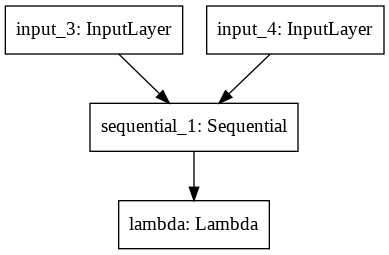

In [30]:
tf.keras.utils.plot_model(malstm)

In [0]:
malstm.summary()
lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            528897      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential_1[0][0]         

In [31]:
model_hist=malstm.fit([train_embeddings1,train_embeddings2],train_similarity,epochs=2,validation_data=([val_embeddings1,val_embeddings2],val_similarity))

Train on 5749 samples, validate on 1379 samples
Epoch 1/2
5749/5749 [==============================] - 44s 8ms/sample - loss: 0.2125 - accuracy: 0.0583 - val_loss: 0.3005 - val_accuracy: 0.0703
Epoch 2/2
5749/5749 [==============================] - 36s 6ms/sample - loss: 0.2466 - accuracy: 0.0637 - val_loss: 0.2387 - val_accuracy: 0.0892


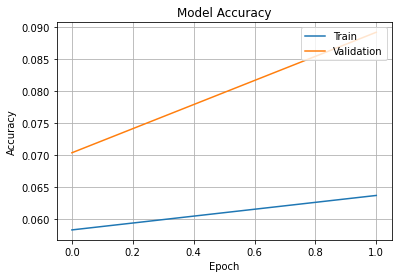

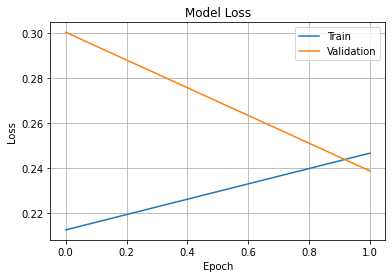

In [43]:
plot_model_history(model_hist)

In [0]:
!pip3 install -q pyyaml h5py 

In [0]:
malstm.save(filepath="STSmmodel.h5",)